In [ ]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Download data from fred

In [ ]:
start = datetime.strptime('2000-01-01','%Y-%m-%d')
end = datetime.strptime('2022-03-28','%Y-%m-%d')
currency_name, code = r'EUR/USD', 'DEXUSEU'

df = data.DataReader(code, start=start, end=end, data_source='fred')[code]
df = df[~np.isnan(df)]
# df = df[:1500]['Close']

Text(0, 0.5, 'EUR/USD Price')

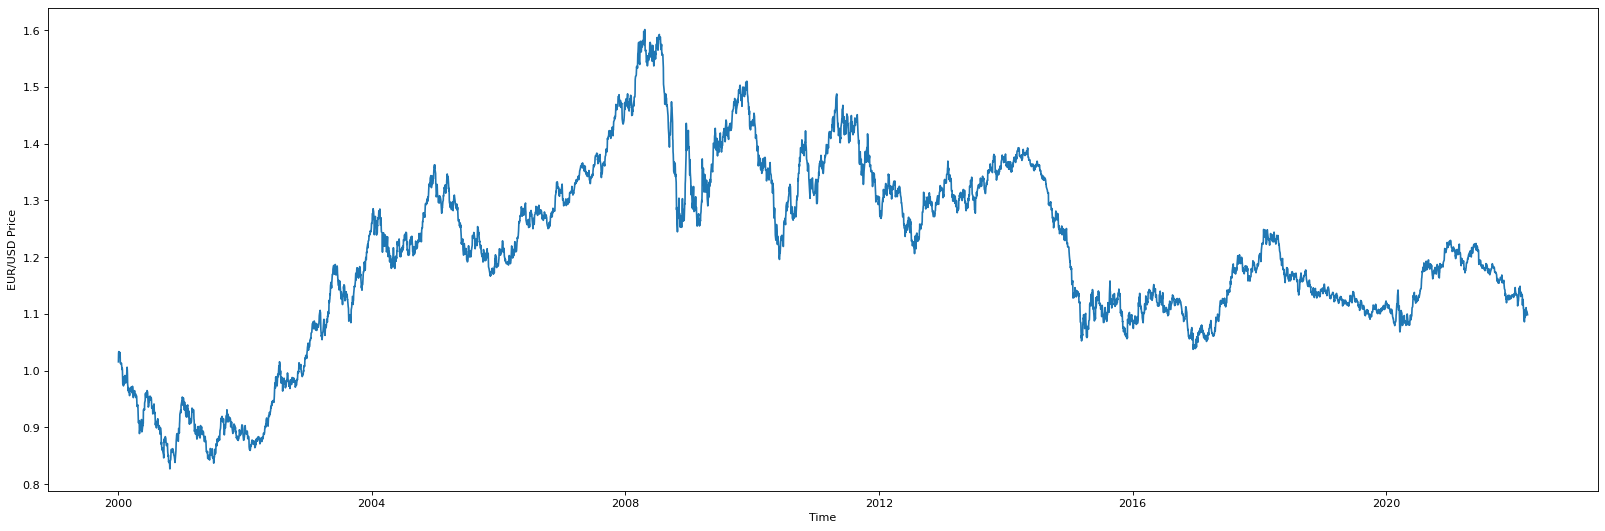

In [ ]:
fig=plt.figure(figsize=(25,8), dpi=80, facecolor ='w', edgecolor='k')
ax=fig.add_subplot(111)
ax.plot(df)
ax.set_xlabel('Time')
ax.set_ylabel('{} Price'.format(currency_name))

## ARIMA Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
def test_stationarity(timeseries):    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
## test whether log(df) is stationary
df_log = np.log(df)
test_stationarity(df_log.dropna()) 

Results of Dickey-Fuller Test:
Test Statistic                   -1.740318
p-value                           0.410468
#Lags Used                        5.000000
Number of Observations Used    5570.000000
Critical Value (1%)              -3.431525
Critical Value (5%)              -2.862059
Critical Value (10%)             -2.567046
dtype: float64


In [ ]:
## test whether diff(log(df)) is stationary => d=1
df_log_diff1 = df_log - df_log.shift()
test_stationarity(df_log_diff1.dropna()) 

Results of Dickey-Fuller Test:
Test Statistic                  -33.711281
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5570.000000
Critical Value (1%)              -3.431525
Critical Value (5%)              -2.862059
Critical Value (10%)             -2.567046
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

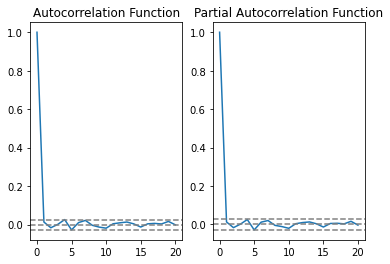

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_diff1.dropna(), nlags=20)
lag_pacf = pacf(df_log_diff1.dropna(), nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
# plt.tight_layout()

In [ ]:
training_size = int(len(df)*0.8)
test_size = len(df)-training_size
train_data, test_data = np.log(df)[0:training_size], np.log(df)[training_size:len(df)]

In [ ]:
model_arima = ARIMA(train_data, order=(2, 1, 0))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.DEXUSEU   No. Observations:                 4459
Model:                 ARIMA(2, 1, 0)   Log Likelihood               16258.859
Method:                       css-mle   S.D. of innovations              0.006
Date:                Thu, 31 Mar 2022   AIC                         -32509.719
Time:                        13:43:44   BIC                         -32484.108
Sample:                             1   HQIC                        -32500.690
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.385e-05   9.36e-05      0.362      0.718      -0.000       0.000
ar.L1.D.DEXUSEU     0.0052      0.015      0.348      0.728      -0.024       0.035
ar.L2.D.DEXUSEU    -0.0153      0.015     -1.022      0.307      -0.045       0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1702           -8.0795j            8.0813           -0.2466
AR.2            0.1702           +8.0795j            8.0813            0.2466
-----------------------------------------------------------------------------
"""

In [ ]:
def evaluate_arima_model(train, test, time_step, arima_order):
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history[-time_step:], order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  
  # calculate out of sample error
  error_mae = mean_absolute_error(test, predictions)
  error_mape = mean_absolute_percentage_error(test, predictions)
  error_rmse = math.sqrt(mean_squared_error(test, predictions))
  return({'mae': error_mae, 'mape': error_mape, 'rmse': error_rmse}, predictions)

In [ ]:
arima_error, predictions = evaluate_arima_model(train_data, test_data, 100, (2,1,0))
arima_error

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'mae': 0.003046155062927198,
 'mape': 0.022701403266623607,
 'rmse': 0.0040349816330011055}

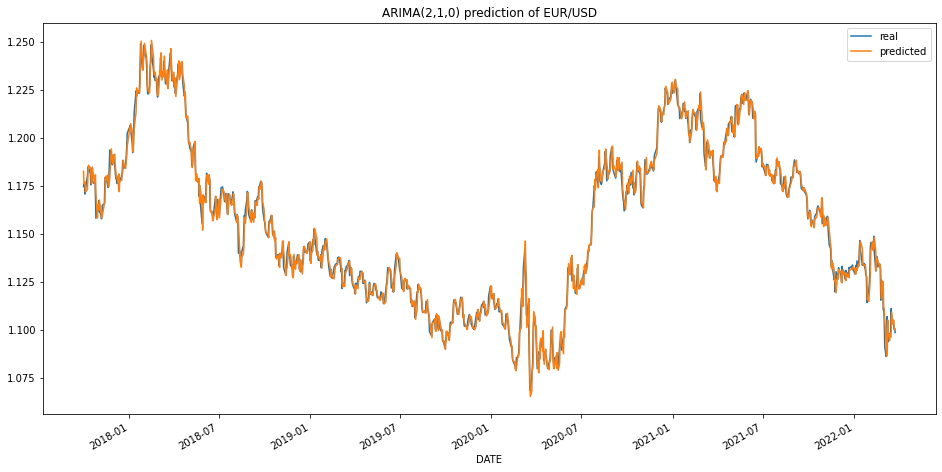

In [ ]:
pd.DataFrame({'real':np.exp(test_data),
              'predicted': np.exp(np.array(predictions).reshape((-1,)))}).plot(figsize=(16,8), title='ARIMA(2,1,0) prediction of {}'.format(currency_name))

## Model LSTM Construction

## Data Preprocessing

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
training_size = int(len(data)*0.8)
test_size = len(data)-training_size
train_data, test_data = data[0:training_size,:],data[training_size:len(data),:]

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [ ]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes = True, show_layer_names = True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
69/69 [==============================] - 22s 215ms/step - loss: 0.0167 - val_loss: 3.6150e-04
Epoch 2/100
69/69 [==============================] - 13s 192ms/step - loss: 9.9510e-04 - val_loss: 2.7437e-04
Epoch 3/100
69/69 [==============================] - 13s 195ms/step - loss: 9.5999e-04 - val_loss: 2.8003e-04
Epoch 4/100
69/69 [==============================] - 13s 193ms/step - loss: 8.4550e-04 - val_loss: 2.3925e-04
Epoch 5/100
69/69 [==============================] - 13s 193ms/step - loss: 7.7433e-04 - val_loss: 2.2598e-04
Epoch 6/100
69/69 [==============================] - 13s 195ms/step - loss: 6.8620e-04 - val_loss: 2.1107e-04
Epoch 7/100
69/69 [==============================] - 14s 202ms/step - loss: 6.5010e-04 - val_loss: 1.9451e-04
Epoch 8/100
69/69 [==============================] - 13s 193ms/step - loss: 6.2109e-04 - val_loss: 2.2111e-04
Epoch 9/100
69/69 [==============================] - 13s 191ms/step - loss: 6.1847e-04 - val_loss: 2.0843e-04
Epoch 10/100
6

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

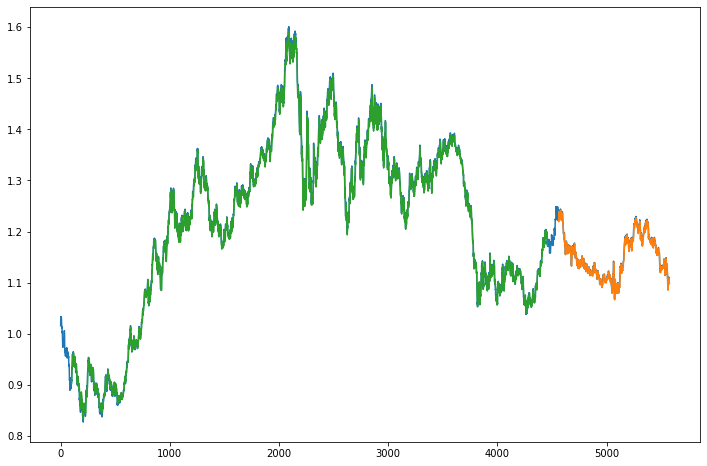

In [35]:
look_back=100
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)

plt.show()

mae: 0.003612280356684338； mape: 0.003137035219558389, rmse: 0.004769791283153096


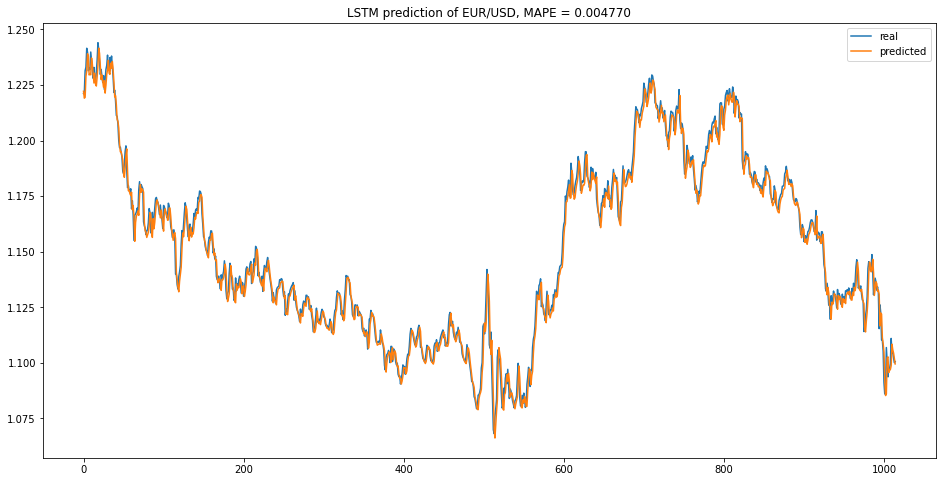

In [36]:
test_data = pd.Series(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1].reshape((-1,)), index= range(len(test_predict)))
test_predictions = pd.Series(test_predict.reshape((-1,)), index= range(len(test_predict)))
error_lstm_mae = mean_absolute_error(test_data, test_predictions)
error_lstm_mape = mean_absolute_percentage_error(test_data, test_predictions)
error_lstm_rmse = math.sqrt(mean_squared_error(test_data, test_predictions))
print('mae: {}； mape: {}, rmse: {}'.format(error_lstm_mae, error_lstm_mape, error_lstm_rmse))
pd.DataFrame({'real':test_data,
              'predicted': test_predictions}).plot(figsize=(16,8), title='LSTM prediction of {}, MAPE = {:.6f}'.format(currency_name, error_lstm_rmse))